# Underwater Object Detection

A project done based on the dataset provided by [Roboflow](https://public.roboflow.com/object-detection/aquarium).

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

device = "cpu"
if torch.cuda.is_available():
  print("All good, a Gpu is available.")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings.")

All good, a Gpu is available.


## Data preparation and visualization utilities

### Unzip the dataset and load content

In [3]:
import zipfile
import os
zip_path = '/content/drive/MyDrive/Acquarium/Aquarium.coco.zip'
extract_path = '/content/Acquarium'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)
print("Subfolders:", os.listdir(extract_path))

Dataset extracted to: /content/Acquarium
Subfolders: ['test', 'train', 'README.dataset.txt', 'valid', 'README.roboflow.txt']


### Explore the dataset and path constants

In [4]:
import os
import json

In [5]:
ROOT_PATH = '/content/Acquarium'
TRAIN_PATH = ROOT_PATH + '/' + 'train/'
TEST_PATH = ROOT_PATH + '/' +  'test/'
VAL_PATH = ROOT_PATH + '/' +  'valid/'


ANN_EXT = '_annotations.coco.json'

with open(TRAIN_PATH + ANN_EXT) as f:
  j = json.load(f)

print("The keys in the json are: ", j.keys())

annotations = j.get("annotations", [])

# Find annotations with category_id 0
category_0_annotations = [ann for ann in annotations if ann.get("category_id") == 0]

if category_0_annotations:
    print(f"Found {len(category_0_annotations)} annotations with category_id 0.")
    for ann in category_0_annotations:
        print(ann)
else:
    print("No annotations with category_id 0 found.")


The keys in the json are:  dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
No annotations with category_id 0 found.


In [6]:
for key in j:
    if isinstance(j[key], list):
        print(f"{key}: {len(j[key])} items")

licenses: 1 items
categories: 8 items
images: 448 items
annotations: 3324 items


In [7]:
categories = []
for category in j['categories']:
  categories.append(category['name'])
  print(category['name'], category['id'])

creatures 0
fish 1
jellyfish 2
penguin 3
puffin 4
shark 5
starfish 6
stingray 7


### Create a custom Dataset class

In [8]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from PIL import Image, ImageFont, ImageDraw
from matplotlib import pyplot as plt
import random
import cv2
import numpy as np
import time
import copy

In [9]:
class AcquariumDataset(Dataset):

  def __init__(self, dir_path, width, height, transforms=None):

    self.dir_path = dir_path

    with open(dir_path + ANN_EXT) as f:
      coco_data = json.load(f)

    self.images = coco_data['images']
    self.annotations = coco_data['annotations']
    self.coco_categories = coco_data['categories']

    self.width = width
    self.height = height

    self.classes = ['__background__', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

    #Map an image to its annotations
    self.image_to_annotations = {}
    for ann in self.annotations:
      image_id = ann['image_id']
      if image_id not in self.image_to_annotations:
        self.image_to_annotations[image_id] = []
      self.image_to_annotations[image_id].append(ann)

    # Map id to category
    self.id_to_cat = {cat['id'] : cat['name'] for cat in self.coco_categories if cat['id'] != 0}

    self.transforms = transforms


  def __getitem__(self, idx):

    img_info = self.images[idx]
    img_path = os.path.join(self.dir_path, img_info['file_name'])

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

    orig_h, orig_w = img.shape[:2]

    if self.width != 0:
      img_resized = cv2.resize(img, (self.width, self.height))
      img_resized = img_resized / 255.0
      x_scale = self.width / orig_w
      y_scale = self.height / orig_h
    else:
      img_resized = img / 255.0
      x_scale=1
      y_scale=1

    anns = self.image_to_annotations.get(img_info['id'],[])
    labels = []
    boxes = []
    for ann in anns:
      labels.append(ann['category_id'])
      x, y, w, h = ann['bbox']
      x_min = x * x_scale
      y_min = y * y_scale
      x_max = (x+w) * x_scale
      y_max = (y+h) * y_scale
      if x_max <= x_min:
          x_max = x_min + 1
      if y_max <= y_min:
          y_max = y_min + 1
      if self.width != 0:
        x_min_final = max(0, min(x_min, self.width - 1))
        x_max_final = max(0, min(x_max, self.width))
        y_min_final = max(0, min(y_min, self.height - 1))
        y_max_final = max(0, min(y_max, self.height))
      else:
        x_min_final = max(0, min(x_min, orig_w - 1))
        x_max_final = max(0, min(x_max, orig_w))
        y_min_final = max(0, min(y_min, orig_h - 1))
        y_max_final = max(0, min(y_max, orig_h))

      new_bbox = [x_min_final, y_min_final, x_max_final, y_max_final]
      boxes.append(new_bbox)

    # Ensure correct tensor shapes
    if len(boxes) == 0:
        boxes = torch.zeros((0, 4), dtype=torch.float32)
    else:
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

    if len(labels) == 0:
        labels = torch.zeros((0,), dtype=torch.int64)
    else:
        labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {
        "boxes": boxes,
        "labels": labels,
        }

    if self.transforms:

      # Convert tensors to numpy lists
      boxes_numpy = boxes.cpu().numpy().tolist()
      labels_numpy = labels.cpu().numpy().tolist()

      transformed = self.transforms(image = img_resized,
                                      bboxes = boxes_numpy,
                                      labels = labels_numpy)

      image_transformed = transformed['image']
      new_boxes_numpy = transformed['bboxes']
      new_labels_numpy = transformed['labels']

      if len(new_boxes_numpy) > 0:
        new_boxes = torch.tensor(new_boxes_numpy, dtype=torch.float32)
        new_labels = torch.tensor(new_labels_numpy, dtype=torch.int64)
      else:
        new_boxes = torch.zeros((0,4), dtype=torch.float32)
        new_labels = torch.zeros((0,), dtype=torch.int64)

      target['boxes'] = new_boxes
      target['labels'] = new_labels

    return image_transformed, target

  def __len__(self):
    return len(self.images)

### Data Augmentations

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_transform():

  return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=45),
            A.Blur(blur_limit=3, p=0.2),
            A.RandomScale(scale_limit=0.2, p=0.3),
            ToTensorV2(p=1.0)
          ],
          bbox_params={"format": "pascal_voc", "label_fields": ["labels"]}
  )

def get_val_transform():
  return A.Compose([
            ToTensorV2(p=1.0)
          ],
          bbox_params={"format": "pascal_voc", "label_fields": ["labels"]}
        )

### Visualization utilities

In [80]:
def generate_colors(num_colors: int):
    """Generates an array with RGB triplets representing colors.

    Args:
        num_colors: the number of colors to generate.

    Returns:
        the generated colors.
    """
    np.random.seed(0)
    colors = np.random.uniform(0, 255, size=(num_colors, 3))
    time_in_ms = 1000 * time.time()
    np.random.seed(int(time_in_ms) % 2 ** 32)

    return colors

def draw_boxes(
    image,
    boxes,
    classes,
    labels,
    colors,
    scores=[],
    add_text = False):
    """Draws a rectangle around each object together with the name of the category
    and the prediction score using a different color for each category.

    Args:
        image: the input image.
        boxes: the bounding boxes in the format [x_min, y_min, x_max, y_max]
               for all the objects in the image.
        classes: the name of the classes for all the objects in the image.
        labels: the labels for all the objects in the image.
        scores: the predicted scores for all the objects in the image.
        colors: the colors to use for each class of object.
        add_text: if true add a box with the name of the category and
                  the score.

    Returns:
        The generated image.
    """
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 10)
    image_with_bb = copy.deepcopy(image)
    painter = ImageDraw.Draw(image_with_bb)

    for i, (box, label) in enumerate(zip(boxes, labels)):
        color = tuple(colors[label].astype(np.int32))

        x_min, y_min, x_max, y_max = box

        coord_bb = [x_min.item(), y_min.item(), x_max.item(), y_max.item()]
        painter.rectangle(coord_bb, outline=color, width=4)

        if add_text:
            class_obj = classes[i]
            score = scores[i]
            text_in_box = f"{class_obj}-{score:.2f}"
            text_bottom = y_max
            text_width, text_height = font.getbbox(text_in_box)[-2:];
            margin = np.ceil(0.05 * text_height)
            painter.rectangle(
                [(x_min, text_bottom - text_height - 2 * margin), (x_min + text_width, text_bottom)],
                fill=color
            )
            painter.text(
                (x_min + margin, text_bottom - text_height - margin),
                text_in_box,
                fill="black",
                font=font
            )

    return image_with_bb


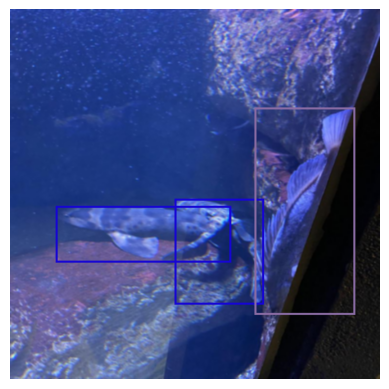

In [13]:
train_data = AcquariumDataset(TRAIN_PATH, 640, 640, get_train_transform())

num = random.randint(1, len(train_data))

img, target = train_data[num]

labels = target['labels']
boxes = target['boxes']
classes_img = [train_data.classes[l.item()] for l in labels]
colors = generate_colors(len(train_data.classes))

drawn_image = draw_boxes(transforms.ToPILImage()(img), boxes, classes_img, labels, colors)
plt.imshow(drawn_image)
plt.axis('off')
plt.show()

## Model definitions and training

### Neccesary train imports

In [14]:
from pathlib import Path
from tqdm import tqdm
!pip install -q wandb
import wandb
!pip install torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.9 MB/s eta 0:00:00


### Fine tune RetinaNet model

In [ ]:
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

In [ ]:
def get_retinanet_50(num_classes):

  model = retinanet_resnet50_fpn_v2(
      weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
  )

  num_anchors = model.head.classification_head.num_anchors

  model.head.classification_head = RetinaNetClassificationHead(
      in_channels = 256,
      num_classes = num_classes,
      num_anchors = num_anchors
  )

  return model

In [ ]:
def train_loop(model,
               num_epochs,
               optimizer,
               scheduler,
               device,
               train_loader,
               val_loader=None):

    global_step = 0

    best_map = 0
    best_model_state = None
    maps =[]
    total_losses = []

    for epoch in tqdm(range(1, num_epochs)):
      model.train()
      losses_per_batch = []
      for idx, (images, targets) in enumerate(train_loader):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        class_loss = loss_dict['classification']
        reg_loss = loss_dict['bbox_regression']
        loss = class_loss + reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_per_batch.append(loss.item())

        if idx % 10 == 0:
          wandb.log({
                    "train/loss_sum": loss,
                    "train/loss_class": class_loss,
                    "train/loss_box_regr": reg_loss,
                    "train/lr": scheduler.get_last_lr()[0]
                    }, step=global_step)
          global_step += 10

      total_losses.append(np.mean(losses_per_batch))

      if val_loader is not None:
            model.eval()
            metric = MeanAveragePrecision()
            with torch.no_grad():
                for images, targets in val_loader:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

                    outputs = model(images)
                    metric.update(outputs, targets)

            map_results = metric.compute()
            current_map = map_results['map'].item() if isinstance(map_results['map'], torch.Tensor) else map_results['map']
            maps.append(current_map)
            if current_map >= best_map:
              print(f"...Saving the best model at epoch {epoch} with mAP {current_map}...")
              best_map = current_map
              best_model_state = copy.deepcopy(model.state_dict())

            # Optionally log to wandb
            wandb.log({
                "val/mAP": map_results['map']
            }, step=global_step)

    return best_model_state, total_losses, maps

def train(model,
          num_epochs,
          optimizer,
          scheduler,
          device,
          wandb_proj,
          run_name,
          train_loader,
          val_loader=None):

  wandb.init(project=wandb_proj, name=run_name)

  best_model_state, total_losses, maps = train_loop(model, num_epochs, optimizer, scheduler, device, train_loader, val_loader)

  wandb.finish()

  path_ckpts = Path("/content/drive/My Drive/Acquarium/ckpts")
  path_ckpts.mkdir(exist_ok=True)
  torch.save(best_model_state, path_ckpts / f"{run_name}.pt")

  return total_losses, maps


In [ ]:
num_workers = 2
batch_size = 8

train_data = AcquariumDataset(TRAIN_PATH, 640, 640, get_train_transform())
val_data = AcquariumDataset(VAL_PATH, 640, 640, get_val_transform())

loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

loader_val = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
retinanet = get_retinanet_50(len(train_data.classes))
retinanet.to(device)

trainable = sum(p.numel() for p in retinanet.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in retinanet.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable}")
print(f"Frozen parameters: {frozen}")

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

do_train = True

num_epochs = 30
lr = 0.001
run_name = f"retina_resnet50_ep_{num_epochs}_bs_{batch_size}"
wandb_project = "Acquarium"

optimizer = torch.optim.SGD(retinanet.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=8,
    threshold=0.005,
    cooldown=1,
)

losses, maps = train(
        retinanet,
        num_epochs,
        optimizer,
        scheduler,
        device,
        wandb_project,
        run_name,
        loader_train,
        loader_val
    )


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
epochs = list(range(1, len(losses)+1))
# Plot classification loss
ax1.plot(epochs, losses, marker='o', color='blue', label='Total loss')
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

  # Plot bbox regression loss
ax2.plot(epochs, maps, marker='o', color='green', label='mAP')
ax2.set_title("Validation mAP")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("mAP")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

Looking at the plots from the various logs on wandb we can see that the model is learning and constantly improving, but at a very slow pace. Because of this I will change to Faster R-CNN to see if better results can be achieved.

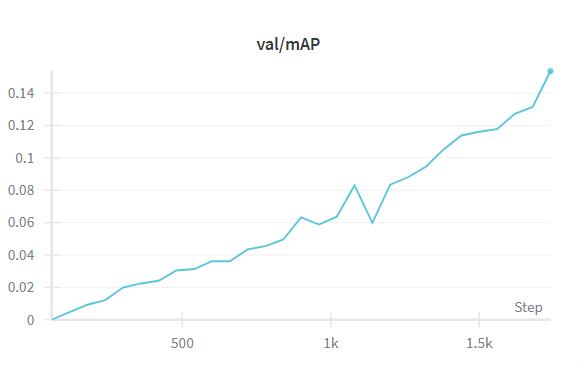

### Fine tune Faster R-CNN

I will adress this task with Faster R-CNN and I will try and compare two different backbones:
- ResNet-50
- MobileNet

#### Training procedure

In [15]:
def train_loop_fasterRCNN(model,
               num_epochs,
               optimizer,
               scheduler,
               device,
               train_loader,
               val_loader=None):

    global_step = 0

    best_map = 0
    best_model_state = None
    maps =[]
    total_losses = []

    for epoch in tqdm(range(1, num_epochs)):
      model.train()
      losses_per_batch = []
      for idx, (images, targets) in enumerate(train_loader):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        losses_per_batch.append(losses.item())

        if idx % 10 == 0:
          wandb.log({
                    "train/loss_sum": losses,
                    "train/lr": scheduler.get_last_lr()[0]
                    }, step=global_step)
          global_step += 10

      total_losses.append(np.mean(losses_per_batch))

      if val_loader is not None:
            model.eval()
            metric = MeanAveragePrecision()
            with torch.no_grad():
                for images, targets in val_loader:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

                    outputs = model(images)
                    metric.update(outputs, targets)

            map_results = metric.compute()
            current_map = map_results['map'].item() if isinstance(map_results['map'], torch.Tensor) else map_results['map']
            maps.append(current_map)
            if current_map >= best_map:
              print(f"...Saving the best model at epoch {epoch} with mAP {current_map}...")
              best_map = current_map
              best_model_state = copy.deepcopy(model.state_dict())

            # Optionally log to wandb
            wandb.log({
                "val/mAP": map_results['map']
            }, step=global_step)

    return best_model_state, total_losses, maps

def train_fasterRCNN(model,
          num_epochs,
          optimizer,
          scheduler,
          device,
          wandb_proj,
          run_name,
          train_loader,
          val_loader=None):

  wandb.init(project=wandb_proj, name=run_name)

  best_model_state, total_losses, maps = train_loop_fasterRCNN(model, num_epochs, optimizer, scheduler, device, train_loader, val_loader)

  wandb.finish()

  path_ckpts = Path("/content/drive/My Drive/Acquarium/ckpts")
  path_ckpts.mkdir(exist_ok=True)
  torch.save(best_model_state, path_ckpts / f"{run_name}.pt")

  return total_losses, maps

#### Mobile net

A much more efficient backbone than ResNet-50 even if it's less powerfull and consequently slightly worse to solve the proposed task.

In [16]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_fasterRCNN(num_classes):

  model = fasterrcnn_mobilenet_v3_large_fpn(weights="COCO_V1")

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features,
        num_classes
    )

  return model

#### ResNet50

In [21]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_fasterRCNN_resnet(num_classes):

  model = fasterrcnn_resnet50_fpn_v2(weights="COCO_V1")

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features,
        num_classes
    )

  return model

#### Train without Data Augmentations Resnet-50

We first train the model without data augmentation. This is done in order to see if the model is able to overfit the dataset manifesting that is it strong enough to learn the key features for tackling the task.

The model obtains a final 0.88 mAP on the training set, which is in fact very good, and means that the model overfits the training set. The test mAP is lower, around 0.37 (when the image is resized) and 0.4 when no resizing takes place.

The next step in our study is to apply data augmentation techniques hoping that the model will be able to generalize in a better way on the test set, even if likely the train mAP will get worse.

In [22]:
num_workers = 2
batch_size = 16

train_data = AcquariumDataset(TRAIN_PATH, 640, 640, get_val_transform())
val_data = AcquariumDataset(VAL_PATH, 640, 640, get_val_transform())

loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

loader_val = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [23]:
fasterRCNN = get_fasterRCNN_resnet(len(train_data.classes))
fasterRCNN.to(device)

trainable = sum(p.numel() for p in fasterRCNN.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in fasterRCNN.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable}")
print(f"Frozen parameters: {frozen}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:00<00:00, 229MB/s]


Trainable parameters: 43061559
Frozen parameters: 225344


In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 24
lr = 0.005
run_name = f"fasterRCNN_resnet_noDA_ep_{num_epochs}_bs_{batch_size}"
wandb_project = "Acquarium"

optimizer = torch.optim.SGD(fasterRCNN.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=8,
    threshold=0.005,
    cooldown=1,
)

losses, maps = train_fasterRCNN(
        fasterRCNN,
        num_epochs,
        optimizer,
        scheduler,
        device,
        wandb_project,
        run_name,
        loader_train,
        loader_val
    )


  4%|▍         | 1/23 [01:09<25:19, 69.05s/it]

...Saving the best model at epoch 1 with mAP 0.06255044043064117...


  9%|▊         | 2/23 [02:17<24:00, 68.61s/it]

...Saving the best model at epoch 2 with mAP 0.16947676241397858...


 13%|█▎        | 3/23 [03:25<22:45, 68.28s/it]

...Saving the best model at epoch 3 with mAP 0.2226826697587967...


 17%|█▋        | 4/23 [04:33<21:35, 68.20s/it]

...Saving the best model at epoch 4 with mAP 0.27316537499427795...


 22%|██▏       | 5/23 [05:41<20:28, 68.24s/it]

...Saving the best model at epoch 5 with mAP 0.30562809109687805...


 26%|██▌       | 6/23 [06:49<19:18, 68.17s/it]

...Saving the best model at epoch 6 with mAP 0.3242931365966797...


 30%|███       | 7/23 [07:57<18:08, 68.04s/it]

...Saving the best model at epoch 7 with mAP 0.33810392022132874...


 35%|███▍      | 8/23 [09:05<16:59, 67.99s/it]

...Saving the best model at epoch 8 with mAP 0.35300469398498535...


 39%|███▉      | 9/23 [10:13<15:51, 67.93s/it]

...Saving the best model at epoch 9 with mAP 0.3541666269302368...


 48%|████▊     | 11/23 [12:28<13:35, 67.93s/it]

...Saving the best model at epoch 11 with mAP 0.368450790643692...


 61%|██████    | 14/23 [15:52<10:09, 67.76s/it]

...Saving the best model at epoch 14 with mAP 0.370564728975296...


 70%|██████▉   | 16/23 [18:07<07:54, 67.77s/it]

...Saving the best model at epoch 16 with mAP 0.37336796522140503...


 96%|█████████▌| 22/23 [24:54<01:07, 67.77s/it]

...Saving the best model at epoch 22 with mAP 0.37546059489250183...


100%|██████████| 23/23 [26:02<00:00, 67.92s/it]


train/loss_sum,█▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mAP,▁▃▅▆▆▇▇▇█▇█████████████
train/loss_sum,0.1087
train/lr,0.005
val/mAP,0.37136


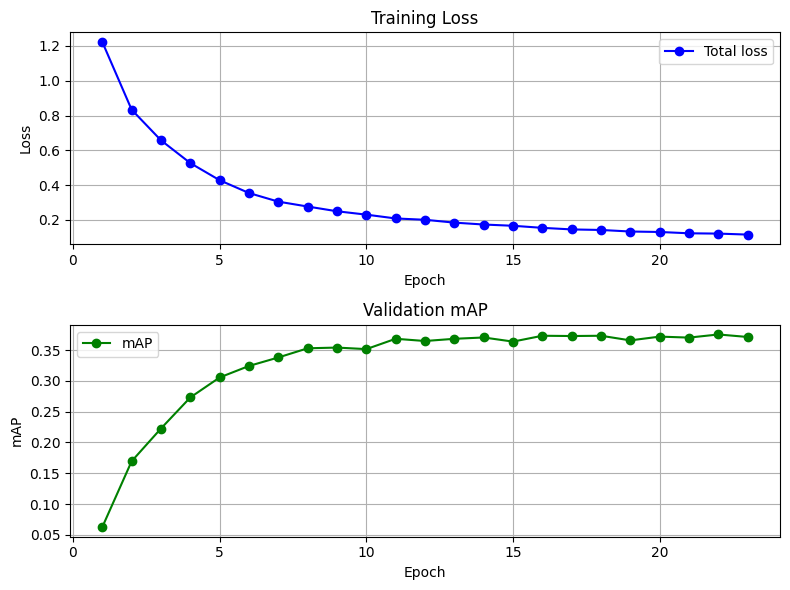

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
epochs = list(range(1, len(losses)+1))
# Plot classification loss
ax1.plot(epochs, losses, marker='o', color='blue', label='Total loss')
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

  # Plot bbox regression loss
ax2.plot(epochs, maps, marker='o', color='green', label='mAP')
ax2.set_title("Validation mAP")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("mAP")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [48]:
def compute_map(data_loader, model):

  model.eval()
  metric = MeanAveragePrecision()
  with torch.no_grad():
    for i, (images, targets) in enumerate(data_loader):
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

                    outputs = model(images)
                    metric.update(outputs, targets)

  map_results = metric.compute()
  return map_results['map'].item() if isinstance(map_results['map'], torch.Tensor) else map_results['map']


In [49]:
map = compute_map(loader_train, fasterRCNN)
print(f"Train mAP: {map}")


Train mAP: 0.8803516030311584


In [50]:
test_data = AcquariumDataset(TEST_PATH, 640, 640, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map = compute_map(test_loader, fasterRCNN)
print(f"Test mAP: {map}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Test mAP: 0.3761568069458008


In [51]:
test_data = AcquariumDataset(TEST_PATH, 0, 0, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map = compute_map(test_loader, fasterRCNN)
print(f"Test mAP: {map}")

Test mAP: 0.3993598520755768


#### Train with Data Augmentations Resnet-50

Adding data augmentation techniques made training much more difficult, in fact the train mAP dropped from 0.88 to 0.5. On the other hand some points were gained with the test set even though an improvement of only 0.04 could be observed.

In [52]:
num_workers = 2
batch_size = 16

train_data = AcquariumDataset(TRAIN_PATH, 640, 640, get_train_transform())
val_data = AcquariumDataset(VAL_PATH, 640, 640, get_val_transform())

loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

loader_val = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [53]:
fasterRCNN = get_fasterRCNN_resnet(len(train_data.classes))
fasterRCNN.to(device)

trainable = sum(p.numel() for p in fasterRCNN.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in fasterRCNN.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable}")
print(f"Frozen parameters: {frozen}")

Trainable parameters: 43061559
Frozen parameters: 225344


In [55]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 35
lr = 0.005
run_name = f"fasterRCNN_resnet_ep_{num_epochs}_bs_{batch_size}"
wandb_project = "Acquarium"

optimizer = torch.optim.SGD(fasterRCNN.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=8,
    threshold=0.005,
    cooldown=1,
)

losses, maps = train_fasterRCNN(
        fasterRCNN,
        num_epochs,
        optimizer,
        scheduler,
        device,
        wandb_project,
        run_name,
        loader_train,
        loader_val
    )


train/loss_sum,█▁
train/lr,▁▁
train/loss_sum,1.36015
train/lr,0.005


  3%|▎         | 1/34 [01:09<38:27, 69.93s/it]

...Saving the best model at epoch 1 with mAP 0.08144532889127731...


  6%|▌         | 2/34 [02:19<37:12, 69.76s/it]

...Saving the best model at epoch 2 with mAP 0.123575359582901...


  9%|▉         | 3/34 [03:28<35:56, 69.57s/it]

...Saving the best model at epoch 3 with mAP 0.1821492463350296...


 12%|█▏        | 4/34 [04:38<34:43, 69.47s/it]

...Saving the best model at epoch 4 with mAP 0.22604957222938538...


 15%|█▍        | 5/34 [05:47<33:32, 69.41s/it]

...Saving the best model at epoch 5 with mAP 0.27766039967536926...


 18%|█▊        | 6/34 [06:57<32:25, 69.47s/it]

...Saving the best model at epoch 6 with mAP 0.30918624997138977...


 21%|██        | 7/34 [08:06<31:16, 69.50s/it]

...Saving the best model at epoch 7 with mAP 0.31050822138786316...


 24%|██▎       | 8/34 [09:15<30:04, 69.41s/it]

...Saving the best model at epoch 8 with mAP 0.35601335763931274...


 29%|██▉       | 10/34 [11:34<27:44, 69.34s/it]

...Saving the best model at epoch 10 with mAP 0.37778812646865845...


 41%|████      | 14/34 [16:11<23:07, 69.36s/it]

...Saving the best model at epoch 14 with mAP 0.3986200988292694...


 50%|█████     | 17/34 [19:39<19:39, 69.40s/it]

...Saving the best model at epoch 17 with mAP 0.41096699237823486...


 94%|█████████▍| 32/34 [36:57<02:18, 69.21s/it]

...Saving the best model at epoch 32 with mAP 0.41187354922294617...


100%|██████████| 34/34 [39:15<00:00, 69.29s/it]


train/loss_sum,██▅▃▃▃▄▃▂▁▃▄▃▃▃▂▃▂▁▃▂▃▂▂▂▁▂▁▃▁▁▃▂▁▂▂▂▁▂▂
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mAP,▁▂▃▄▅▆▆▇▆▇▇▇▇██▇██▇▇▇███▇█▇▇█▇██▇█
train/loss_sum,0.35955
train/lr,0.005
val/mAP,0.41146


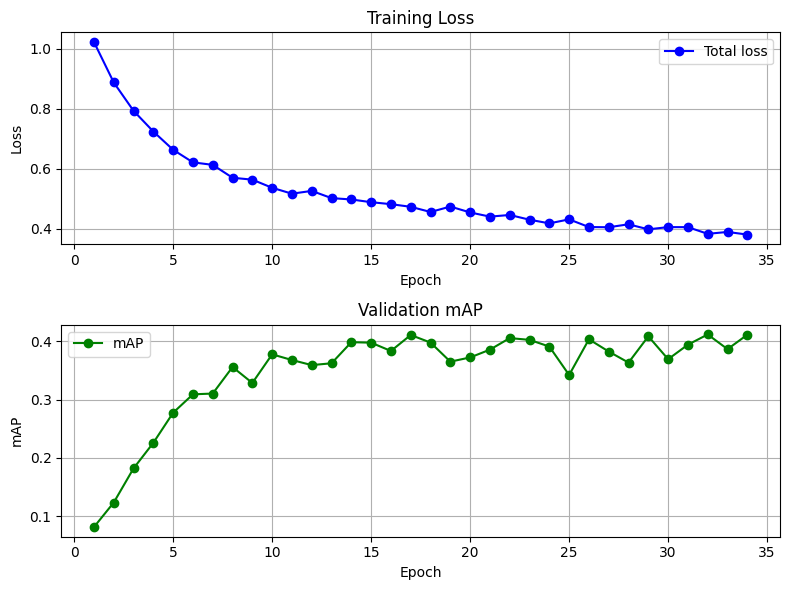

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
epochs = list(range(1, len(losses)+1))
# Plot classification loss
ax1.plot(epochs, losses, marker='o', color='blue', label='Total loss')
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Plot bbox regression loss
ax2.plot(epochs, maps, marker='o', color='green', label='mAP')
ax2.set_title("Validation mAP")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("mAP")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [57]:
map = compute_map(loader_train, fasterRCNN)
print(f"Train mAP: {map}")

Train mAP: 0.4994339048862457


In [59]:
test_data = AcquariumDataset(TEST_PATH, 640, 640, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map_resnet_DA_test_rs = compute_map(test_loader, fasterRCNN)
print(f"Test mAP resized: {map_resnet_DA_test_rs}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Test mAP resized: 0.4126049280166626


In [62]:
test_data = AcquariumDataset(TEST_PATH, 0, 0, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map_resnet_DA_test_nors = compute_map(test_loader, fasterRCNN)
print(f"Test mAP not resized: {map_resnet_DA_test_nors}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Test mAP not resized: 0.4147593379020691


#### Train with Data Augmentations MobileNet

In [109]:
num_workers = 2
batch_size = 16

train_data = AcquariumDataset(TRAIN_PATH, 640, 640, get_train_transform())
val_data = AcquariumDataset(VAL_PATH, 640, 640, get_val_transform())

loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

loader_val = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
fasterRCNN = get_fasterRCNN(len(train_data.classes))
fasterRCNN.to(device)

trainable = sum(p.numel() for p in fasterRCNN.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in fasterRCNN.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable}")
print(f"Frozen parameters: {frozen}")

Trainable parameters: 18902083
Frozen parameters: 58896


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

do_train = True

num_epochs = 50
lr = 0.005
run_name = f"fasterRCNN_mobilenet_ep_{num_epochs}_bs_{batch_size}"
wandb_project = "Acquarium"

optimizer = torch.optim.SGD(fasterRCNN.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=8,
    threshold=0.005,
    cooldown=1,
)

losses, maps = train_fasterRCNN(
        fasterRCNN,
        num_epochs,
        optimizer,
        scheduler,
        device,
        wandb_project,
        run_name,
        loader_train,
        loader_val
    )


  2%|▏         | 1/49 [00:21<16:48, 21.00s/it]

...Saving the best model at epoch 1 with mAP 0.04681937023997307...


  4%|▍         | 2/49 [00:41<15:59, 20.41s/it]

...Saving the best model at epoch 2 with mAP 0.09286531805992126...


  6%|▌         | 3/49 [01:01<15:30, 20.24s/it]

...Saving the best model at epoch 3 with mAP 0.14153915643692017...


  8%|▊         | 4/49 [01:20<15:04, 20.11s/it]

...Saving the best model at epoch 4 with mAP 0.182945117354393...


 10%|█         | 5/49 [01:40<14:40, 20.00s/it]

...Saving the best model at epoch 5 with mAP 0.20758099853992462...


 12%|█▏        | 6/49 [02:00<14:13, 19.84s/it]

...Saving the best model at epoch 6 with mAP 0.22709189355373383...


 14%|█▍        | 7/49 [02:19<13:49, 19.75s/it]

...Saving the best model at epoch 7 with mAP 0.2601769268512726...


 16%|█▋        | 8/49 [02:39<13:26, 19.66s/it]

...Saving the best model at epoch 8 with mAP 0.2710328996181488...


 18%|█▊        | 9/49 [02:58<13:04, 19.62s/it]

...Saving the best model at epoch 9 with mAP 0.2875356674194336...


 20%|██        | 10/49 [03:18<12:44, 19.60s/it]

...Saving the best model at epoch 10 with mAP 0.2958429753780365...


 22%|██▏       | 11/49 [03:37<12:21, 19.50s/it]

...Saving the best model at epoch 11 with mAP 0.30645057559013367...


 27%|██▋       | 13/49 [04:16<11:39, 19.43s/it]

...Saving the best model at epoch 13 with mAP 0.31135615706443787...


 29%|██▊       | 14/49 [04:35<11:16, 19.33s/it]

...Saving the best model at epoch 14 with mAP 0.3176461458206177...


 31%|███       | 15/49 [04:54<10:56, 19.31s/it]

...Saving the best model at epoch 15 with mAP 0.32642462849617004...


 33%|███▎      | 16/49 [05:13<10:34, 19.24s/it]

...Saving the best model at epoch 16 with mAP 0.3306081295013428...


 47%|████▋     | 23/49 [07:25<08:06, 18.70s/it]

...Saving the best model at epoch 23 with mAP 0.3338225483894348...


 53%|█████▎    | 26/49 [08:21<07:11, 18.77s/it]

...Saving the best model at epoch 26 with mAP 0.34017667174339294...


 59%|█████▉    | 29/49 [09:16<06:12, 18.60s/it]

...Saving the best model at epoch 29 with mAP 0.3418695628643036...


 63%|██████▎   | 31/49 [09:54<05:34, 18.60s/it]

...Saving the best model at epoch 31 with mAP 0.34243154525756836...


 76%|███████▌  | 37/49 [11:44<03:41, 18.42s/it]

...Saving the best model at epoch 37 with mAP 0.35114210844039917...


 82%|████████▏ | 40/49 [12:39<02:45, 18.41s/it]

...Saving the best model at epoch 40 with mAP 0.35672277212142944...


100%|██████████| 49/49 [15:24<00:00, 18.88s/it]


train/loss_sum,█▄▃▅▄▃▃▂▄▃▃▃▂▃▂▃▁▂▃▁▁▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▂▁▃▂
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mAP,▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████▇██████████▇██
train/loss_sum,0.64167
train/lr,0.005
val/mAP,0.34598


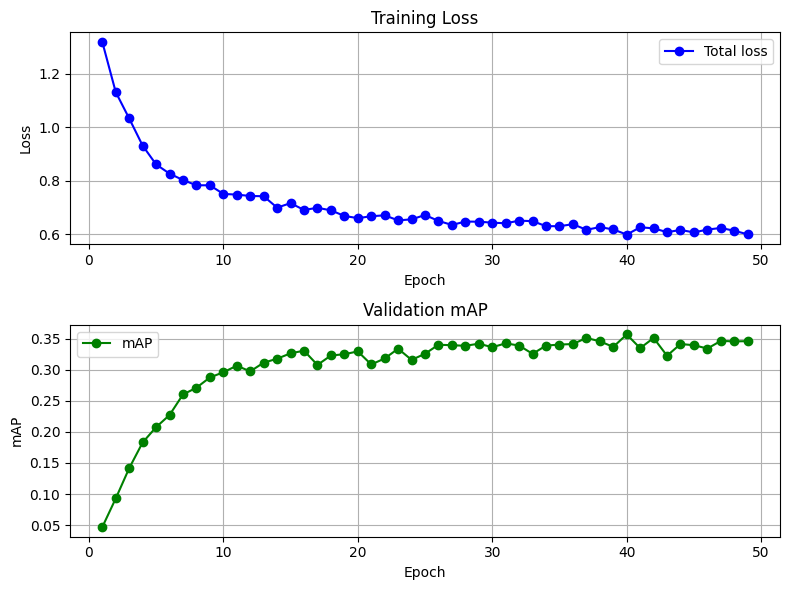

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
epochs = list(range(1, len(losses)+1))
# Plot classification loss
ax1.plot(epochs, losses, marker='o', color='blue', label='Total loss')
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

  # Plot bbox regression loss
ax2.plot(epochs, maps, marker='o', color='green', label='mAP')
ax2.set_title("Validation mAP")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("mAP")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [110]:
mobilenet = get_fasterRCNN(len(train_data.classes))
mobilenet.to(device)
checkpoint = "fasterRCNN_mobilenet_ep_50_bs_16.pt"
root_ckpts = Path("/content/drive/My Drive/Acquarium/ckpts")
path_ckpt = root_ckpts / f"{checkpoint}"
mobilenet.load_state_dict(torch.load(path_ckpt, weights_only=True, map_location=device))


map = compute_map(loader_train, mobilenet)
print(f"Train mAP: {map}")

test_data = AcquariumDataset(TEST_PATH, 640, 640, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map_mobilenet_test_rs = compute_map(test_loader, mobilenet)
print(f"Test mAP resized: {map_mobilenet_test_rs}")

test_data = AcquariumDataset(TEST_PATH, 0, 0, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map_mobilenet_test_nors = compute_map(test_loader, mobilenet)
print(f"Test mAP not resized: {map_mobilenet_test_nors}")

Train mAP: 0.5366488695144653
Test mAP resized: 0.3628789484500885
Test mAP not resized: 0.019441654905676842


#### Train without Data Augmentations MobileNet

Here I will try and train the FasterRCNN without using any data augmentation to monitor what will happen. We should like to detect overfitting, that would show the model's ability to learn with a very high precision the training set. If that doesn't happen it means that it's to weak to learn the crucial features of the dataset. In fact from the final mAP computations we can conclude that the model is not completely able to overfit.

In [107]:
num_workers = 2
batch_size = 16

train_data = AcquariumDataset(TRAIN_PATH, 640, 640, get_val_transform())
val_data = AcquariumDataset(VAL_PATH, 640, 640, get_val_transform())

loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

loader_val = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [19]:
fasterRCNN = get_fasterRCNN(len(train_data.classes))
fasterRCNN.to(device)

trainable = sum(p.numel() for p in fasterRCNN.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in fasterRCNN.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable}")
print(f"Frozen parameters: {frozen}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:01<00:00, 47.4MB/s]


Trainable parameters: 18902083
Frozen parameters: 58896


In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 50
lr = 0.005
run_name = f"fasterRCNN_mobilenet_noDA_ep_{num_epochs}_bs_{batch_size}"
wandb_project = "Acquarium"

optimizer = torch.optim.SGD(fasterRCNN.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=8,
    threshold=0.005,
    cooldown=1,
)

losses, maps = train_fasterRCNN(
        fasterRCNN,
        num_epochs,
        optimizer,
        scheduler,
        device,
        wandb_project,
        run_name,
        loader_train,
        loader_val
    )


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tomazcotic02 (tomazcotic02-universit-di-bologna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  2%|▏         | 1/49 [00:21<16:59, 21.24s/it]

...Saving the best model at epoch 1 with mAP 0.055228061974048615...


  4%|▍         | 2/49 [00:39<15:15, 19.48s/it]

...Saving the best model at epoch 2 with mAP 0.1162571981549263...


  6%|▌         | 3/49 [00:57<14:25, 18.81s/it]

...Saving the best model at epoch 3 with mAP 0.1799655258655548...


  8%|▊         | 4/49 [01:15<13:51, 18.47s/it]

...Saving the best model at epoch 4 with mAP 0.22963806986808777...


 10%|█         | 5/49 [01:33<13:19, 18.16s/it]

...Saving the best model at epoch 5 with mAP 0.26794150471687317...


 12%|█▏        | 6/49 [01:50<12:50, 17.92s/it]

...Saving the best model at epoch 6 with mAP 0.2891613841056824...


 14%|█▍        | 7/49 [02:07<12:24, 17.73s/it]

...Saving the best model at epoch 7 with mAP 0.30388227105140686...


 18%|█▊        | 9/49 [02:42<11:37, 17.44s/it]

...Saving the best model at epoch 9 with mAP 0.30697065591812134...


 29%|██▊       | 14/49 [04:07<09:54, 17.00s/it]

...Saving the best model at epoch 14 with mAP 0.3104200065135956...


100%|██████████| 49/49 [13:32<00:00, 16.59s/it]


train/loss_sum,█▇▃▄▄▃▂▃▂▃▂▂▃▂▃▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▂▂▂▁▁▂▁▂▂▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mAP,▁▃▄▆▇████████████▇██████████████████████
train/loss_sum,0.33328
train/lr,0.005
val/mAP,0.2981


Here the plot from wandb of the validation mAP for the model, that out of all the models is the worse performing one.

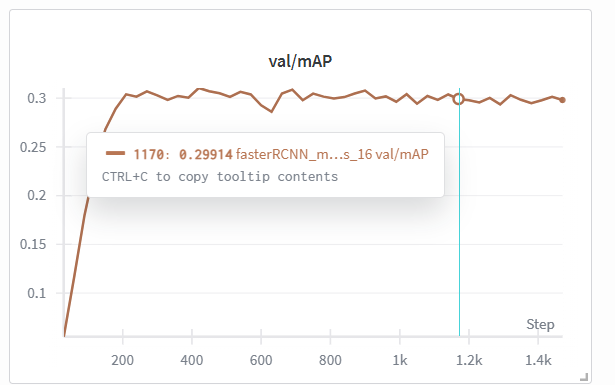

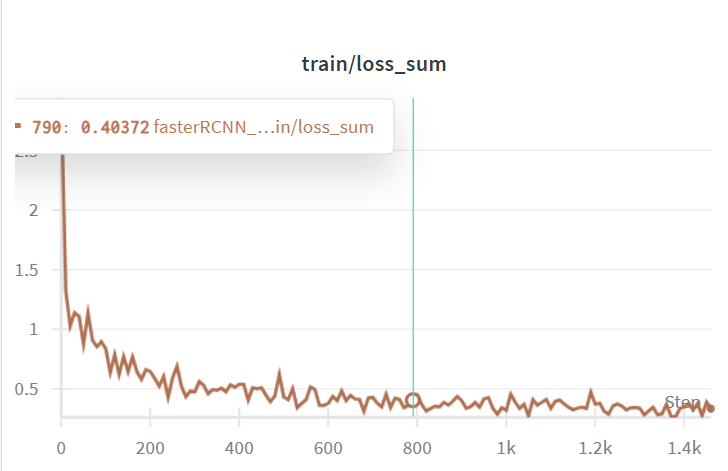

In [108]:
noDA_mobilenet = get_fasterRCNN(len(train_data.classes))
noDA_mobilenet.to(device)
checkpoint = "fasterRCNN_mobilenet_noDA_ep_50_bs_16.pt"
root_ckpts = Path("/content/drive/My Drive/Acquarium/ckpts")
path_ckpt = root_ckpts / f"{checkpoint}"
noDA_mobilenet.load_state_dict(torch.load(path_ckpt, weights_only=True, map_location=device))


map = compute_map(loader_train, noDA_mobilenet)
print(f"Train mAP: {map}")

test_data = AcquariumDataset(TEST_PATH, 640, 640, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map_mobilenet_noDA_test_rs = compute_map(test_loader, noDA_mobilenet)
print(f"Test mAP resized: {map_mobilenet_noDA_test_rs}")

test_data = AcquariumDataset(TEST_PATH, 0, 0, get_val_transform())
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

map_mobilenet_noDA_test_nors = compute_map(test_loader, noDA_mobilenet)
print(f"Test mAP not resized: {map_mobilenet_noDA_test_nors}")

Train mAP: 0.6495553851127625
Test mAP resized: 0.3391164541244507
Test mAP not resized: 0.34251466393470764


## Performance summaries


From the table below we can see that the best performing model is the Faster R-CNN that uses a backbone of Resnet-50 in combination with data augmentation techniques.

We can extract two information from the experiments:
- The first and the most obvious is that the power we reserve to the feature extractor is very important. As a matter of fact ResNet-50 has many more parameters than MobileNet and this is also reflected in the performance.
- The second more subtle (and with less impact) is the importance of data augmentation techniques. Their effect is strongly visible in the ResNet-50 experiment, where without applying them the model strongly overfits the training data. For the MobileNet backbone it's also important even if the model is not completely able to overfit the data because of its limited capacity.



| Backbone           | Train mAP | Valid mAP | Test mAP |
|-----------------|-----------|-----------|-----------|
| ResNet-50 (DA)  | 0.5      | 0.41      | 0.41      |
| ResNet-50 (noDA)     | 0.88      | 0.37      | 0.37      |
| MobileNet (DA)           | 0.54      | 0.36      | 0.01      |
| MobileNet (noDA)           | 0.65      | 0.31      | 0.34      |


P.s.: Notice that the comparison is not bullet-proof. The number of epochs on which model were trained is different because of the fact that some backbones were a lot faster to train than others. I also didn't throughfully explore all the hyperparameter tunings for each backbone separately but I applied for example SGD as the optimizer for everything because it severely outperformed AdamW for the model with ResNet-50.


It follows the plot of the validation mAP for all the tried models and backbones, where the slowness in imporving the quality of the solution of retinanet is evident.

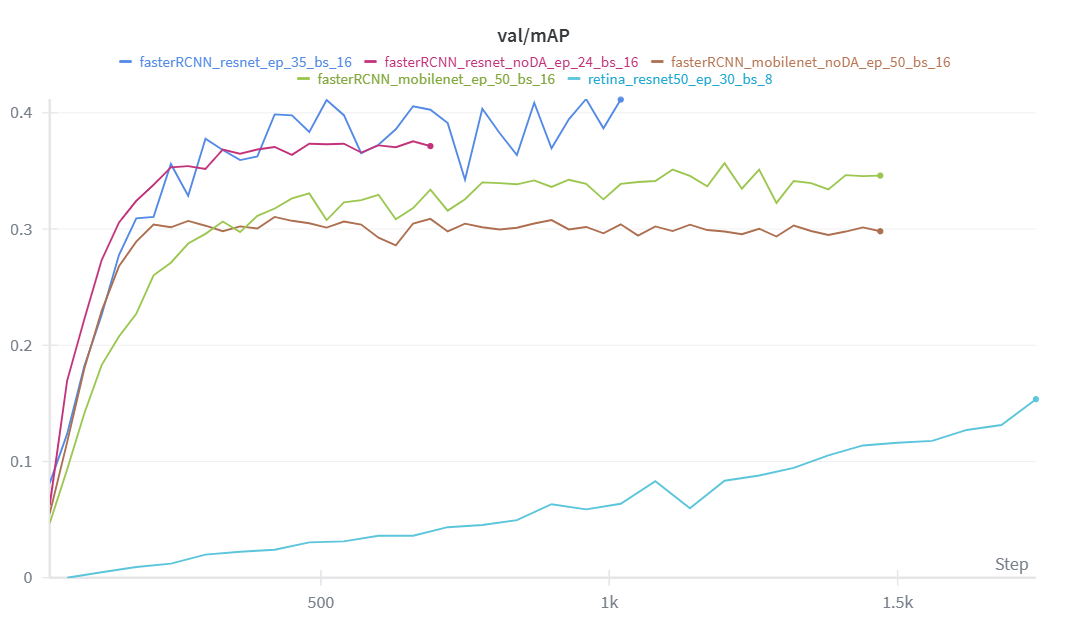

## Inference

### Detect objects and postprocessing

In [33]:
from torchvision.ops import nms

def postprocess(boxes, scores, labels, score_thresh, iou_thresh):

  keep = scores >= score_thresh

  # Ensure right format when outputs if no detections
  if keep.sum() == 0:
      return torch.empty((0,4)), torch.empty((0,)), torch.empty((0,), dtype=torch.long)

  boxes = boxes[keep]
  scores = scores[keep]
  labels = labels[keep]

  keep_idxs = torchvision.ops.nms(boxes, scores, iou_thresh)

  return boxes[keep_idxs], scores[keep_idxs], labels[keep_idxs]

In [36]:
def detect_objects(detector, image, categories, score_thresh, iou_thresh):

  detector.eval()
  with torch.no_grad():
    predictions = detector(image)

  boxes = predictions[0]['boxes'].detach().cpu().numpy()
  labels = predictions[0]['labels'].detach().cpu().numpy()
  scores = predictions[0]['scores'].detach().cpu().numpy()

  categories = [categories[labels[i]] for i in range(len(scores))]

  boxes, scores, labels = postprocess(torch.from_numpy(boxes),
                                      torch.from_numpy(scores),
                                      torch.from_numpy(labels),
                                      score_thresh,
                                      iou_thresh)

  return boxes, labels, scores, categories

### Inference

An interative demonstration of object detection with the four different trained backbones, adding the possibility to change the postprocessing thresholds and performing inference on images of the original size.

Here if we change the dataset from test to train and use the ResNet-50 (noDA) we can see how precise the model is - final proof of overfitting.

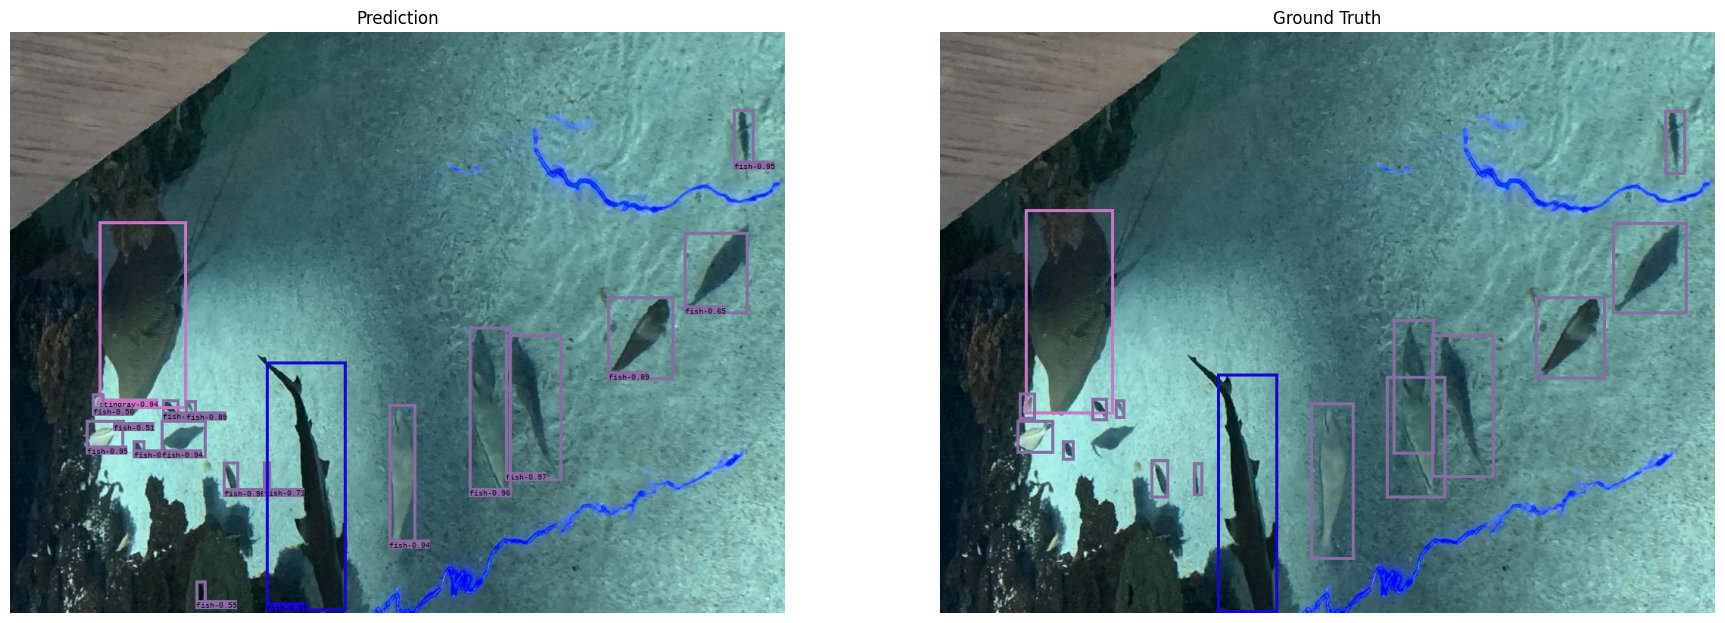

In [152]:
#@title Show predictions {run:"auto", display-mode:"form"}
sample_index = 9  #@param {type:"slider", min:0, max:64, step:1}
score_thresh = 0.31  #@param {type:"slider", min:0.0, max:1.0, step:0.01}
iou_thresh = 0.27 #@param {type:"slider", min:0.0, max:1.0, step:0.01}
checkpoint = "fasterRCNN_resnet_ep_35_bs_16.pt"  #@param ["fasterRCNN_mobilenet_ep_50_bs_16.pt", "fasterRCNN_mobilenet_noDA_ep_50_bs_16.pt", "fasterRCNN_resnet_noDA_ep_24_bs_16.pt", "fasterRCNN_resnet_ep_35_bs_16.pt"]
show_text = True  #@param {type:"boolean"}
resizing = False  #@param {type:"boolean"}

if resizing:
  test_data = AcquariumDataset(TEST_PATH, 640, 640, get_val_transform())
else:
  test_data = AcquariumDataset(TEST_PATH, 0, 0, get_val_transform())

train_data = AcquariumDataset(TRAIN_PATH, 640, 640, get_val_transform())

root_ckpts = Path("/content/drive/My Drive/Acquarium/ckpts")

if "resnet" in checkpoint:
  object_detector = get_fasterRCNN_resnet(8)
elif "mobilenet" in checkpoint:
  object_detector = get_fasterRCNN(8)

path_ckpt = root_ckpts / f"{checkpoint}"
object_detector.load_state_dict(torch.load(path_ckpt, weights_only=True, map_location=device))
object_detector.to(device)

image, targets = test_data[sample_index]
image = image.unsqueeze(0).to(device)
boxes, labels, scores, categories = detect_objects(object_detector, image, test_data.classes, score_thresh, iou_thresh)

image = transforms.ToPILImage()(image[0])
image_with_bb_pred = draw_boxes(image, boxes, categories, labels, colors, scores, add_text=show_text)
image_with_bb_gt = draw_boxes(image, targets['boxes'], categories, targets['labels'], colors, [1.0] * len(targets["boxes"]), add_text=False)

plt.rcParams["figure.figsize"] = 22, 16

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(image_with_bb_pred)
axarr[0].set_title("Prediction")
axarr[0].axis("off")

axarr[1].imshow(image_with_bb_gt)
axarr[1].set_title("Ground Truth")
axarr[1].axis("off")
plt.show()

